In [3]:
import numpy
numpy.sqrt(6.4 * 6.4 + 0.28*0.28)

6.4061220718934173

In [8]:
((1 - 65.7 / 70.2) ** 2 + (1 - 70.2 / 70.4)**2)**0.5

0.06416548518468593

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Compare MC datasets

In [3]:
import pandas
import root_numpy

In [4]:
from itertools import combinations
from utils import add_diff_pt

def add_features(data, event_id_column='event_id'):
    event_id = data.run.apply(str) + '_' + data.event.apply(str)
    data['group_column'] = numpy.unique(event_id, return_inverse=True)[1]
    # all weights are 1, because this is MC
    data[event_id_column] = event_id
    data['N_sig_sw'] = 1
    add_diff_pt(data)
    # add cos(diff_phi)
    data.loc[:, 'cos_diff_phi'] = numpy.cos(data.diff_phi.values)
    PIDs = {'k': data.PIDNNk.values,
            'e': data.PIDNNe.values,
            'mu': data.PIDNNm.values,
           }
    for (pid_name1, pid_values1), (pid_name2, pid_values2) in combinations(PIDs.items(), 2):
        data.loc[:, 'max_PID_{}_{}'.format(pid_name1, pid_name2)] = numpy.maximum(pid_values1, pid_values2)
        data.loc[:, 'sum_PID_{}_{}'.format(pid_name1, pid_name2)] = pid_values1 + pid_values2

In [5]:
data_kstar = pandas.DataFrame(root_numpy.root2array('datasets/MC/csv/Bd_JPsiKstar/Tracks.root'))
data_kstar = data_kstar.ix[numpy.isfinite(data_kstar.IPs), :]
add_features(data_kstar)

In [6]:
data_kstar['label'] = data_kstar.signB.values * data_kstar.signTrack.values > 0

In [7]:
data = pandas.DataFrame(root_numpy.root2array('datasets/MC/csv/Bu_JPsiK/Tracks.root'))
data = data.ix[numpy.isfinite(data.IPs), :]
add_features(data)

In [8]:
data['label'] = data.signB.values * data.signTrack.values > 0

In [9]:
selection = " ((PIDNNk > 0) | (PIDNNm > 0) | (PIDNNe > 0) | (PIDNNpi > 0) | (PIDNNp > 0)) & (ghostProb < 0.4)"

In [10]:
data = data.query(selection)
data_kstar = data_kstar.query(selection)

In [33]:
data['etaB'] = data.diff_eta.values + data.eta.values
data_kstar['etaB'] = data_kstar.diff_eta.values + data_kstar.eta.values

In [36]:
features = ['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 
            'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm',
            'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 
            'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs', 'etaB']

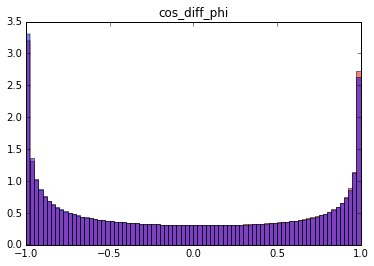

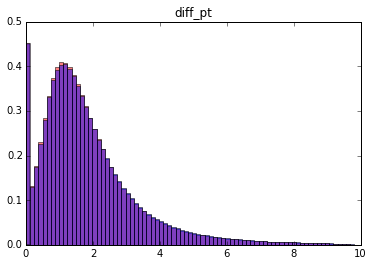

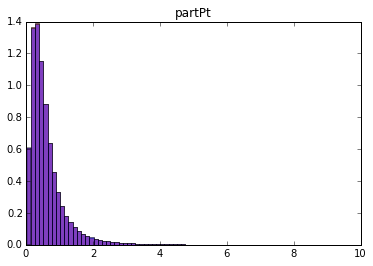

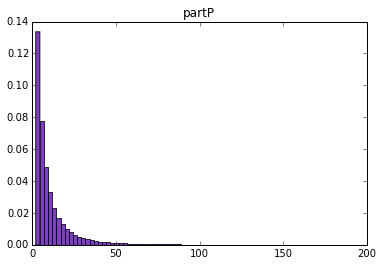

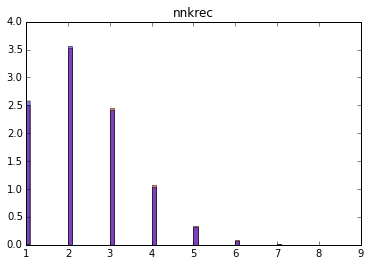

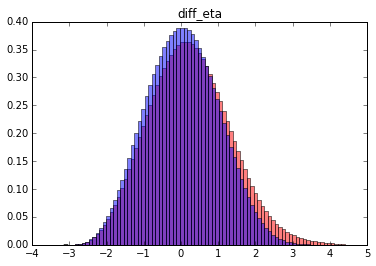

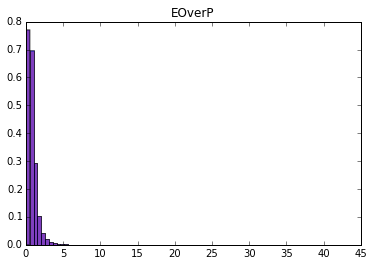

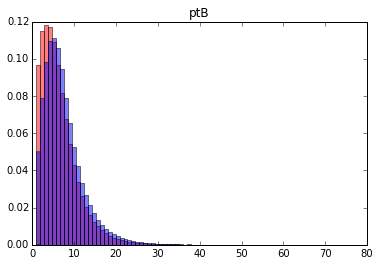

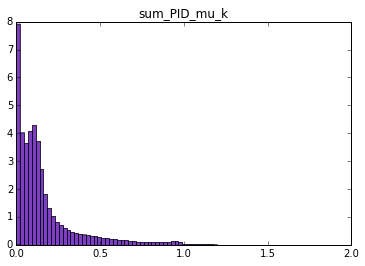

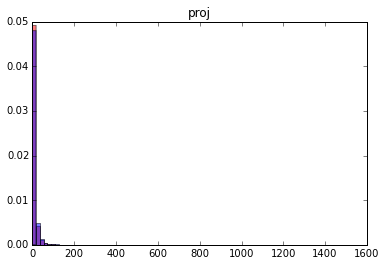

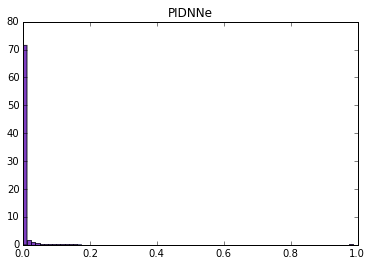

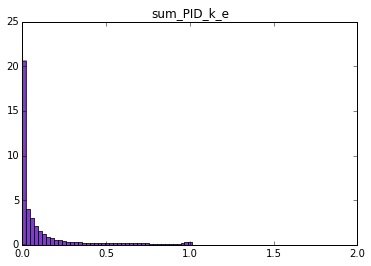

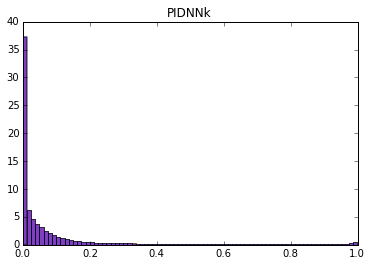

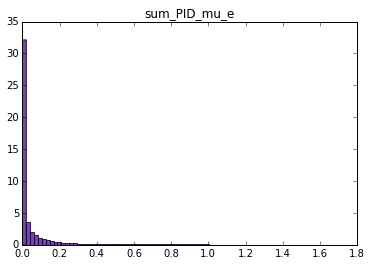

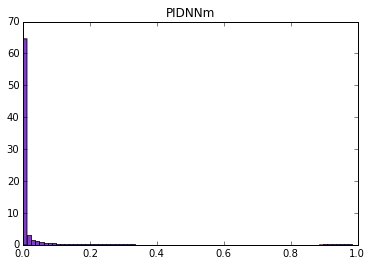

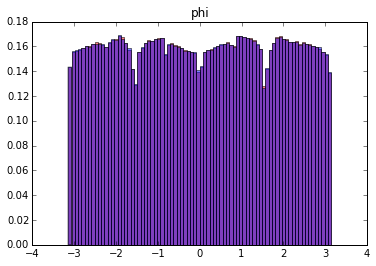

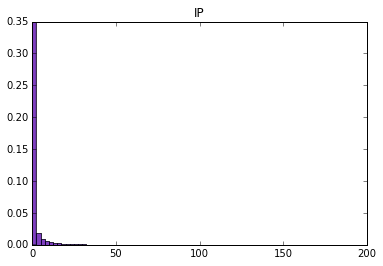

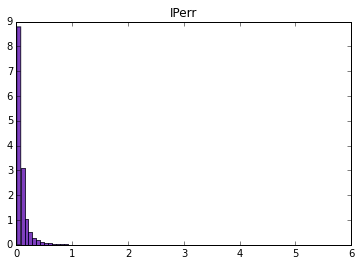

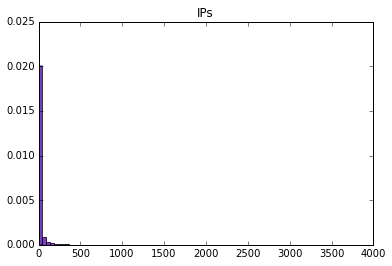

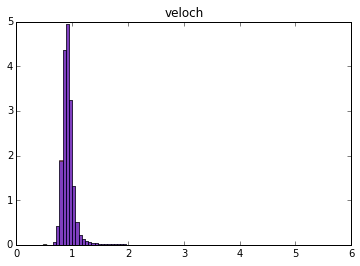

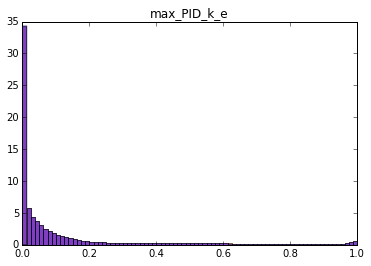

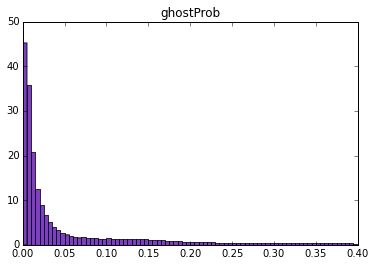

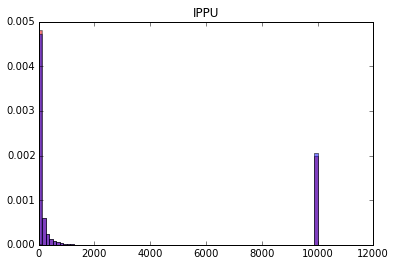

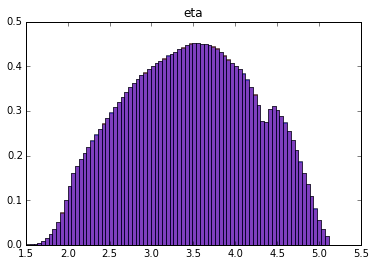

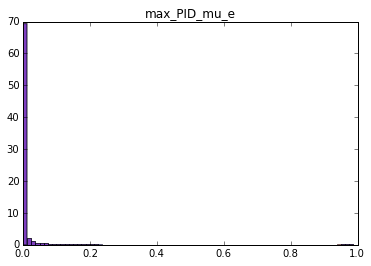

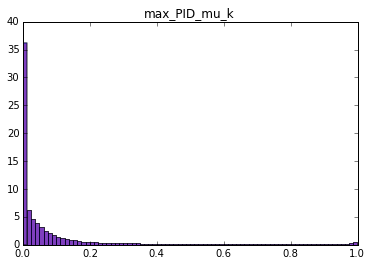

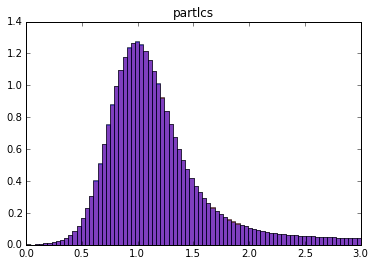

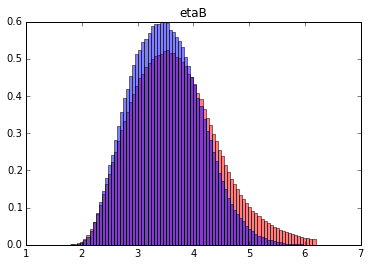

In [39]:
for f in features:
    mask1 = data[f].values > -999
    mask2 = data_kstar[f].values > -999
    x1 = max(numpy.min(data.loc[mask1, f]), numpy.min(data_kstar.loc[mask2, f]))
    x2 = min(numpy.max(data.loc[mask2, f]), numpy.max(data_kstar.loc[mask2, f]))
    hist(data.loc[:, f].values, bins=80, alpha=0.5, normed=True, range=(x1, x2))
    hist(data_kstar.loc[:, f].values, bins=80, alpha=0.5, normed=True, range=(x1, x2))
    title(f)
    show()

In [ ]:
_, n_tracks_all = numpy.unique(data.event_id, return_counts=True)
_, n_tracks_all_kstar = numpy.unique(data_kstar.event_id, return_counts=True)

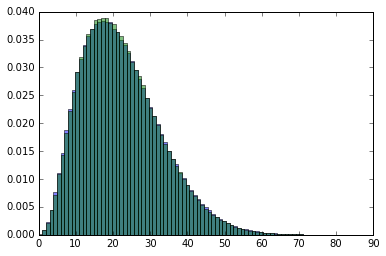

In [35]:
hist(n_tracks_all, bins=81, normed=True, range=(0, 80), alpha=0.5)  
hist(n_tracks_all_kstar, bins=81, normed=True, range=(0, 80), alpha=0.5)    
pass

In [13]:
data_all = pandas.concat([data, data_kstar])

In [14]:
data_all['group_column'] = numpy.unique(data_all.event_id, return_inverse=True)[1]

In [15]:
data_all_part = data_all[data_all.e_cut == 1]

In [16]:
labels_all = [1] * len(data) + [0] * len(data_kstar)

In [17]:
labels_all_part = [1] * sum(data.e_cut == 1) + [0] * sum(data_kstar.e_cut == 1)

In [24]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier
from folding_group import FoldingGroupClassifier

tt_base = DecisionTrainClassifier(learning_rate=0.05, n_estimators=1000, depth=6,
                                  max_features=20, n_threads=12)
tt_folding = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                    train_features=features, group_feature='group_column')
%time tt_folding.fit(data_all_part, labels_all_part)
pass

CPU times: user 11.4 s, sys: 4 ms, total: 11.4 s
Wall time: 1.19 s


In [25]:
p = tt_folding.predict_proba(data_all_part)[:, 1]

KFold prediction using folds column


In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(labels_all_part, p)

0.58588662436209415

In [28]:
steps = []
for p in tt_folding.staged_predict_proba(data_all_part):
    steps.append(roc_auc_score(labels_all_part, p[:, 1]))

KFold prediction using folds column


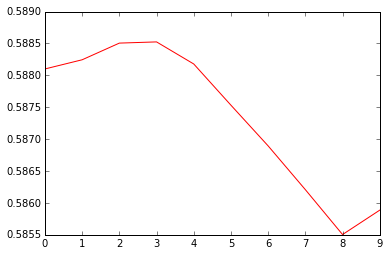

In [29]:
plot(range(len(steps)), steps)

In [30]:
a = tt_folding.get_feature_importances()
a.sort_values(by='effect', ascending=False)

,effect
ptB,1.000000
diff_eta,0.422581
IPPU,0.332258
veloch,0.329032
phi,0.312903
IPerr,0.306452
EOverP,0.303226
proj,0.303226
ghostProb,0.300000
cos_diff_phi,0.267742


In [ ]:
auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprobs_calib, Bweight, N_B_events)
#         print auc, auc_full

----------------------------

In [2]:
import pandas
import root_numpy

In [3]:
a = root_numpy.root2array('datasets/old_tagging/nnet_vtx.root')

In [5]:
b = root_numpy.root2array('datasets/data/csv/JPsiK/Vertices.root', selection='v_cut==1')

In [6]:
b = pandas.DataFrame(b)

In [7]:
a = pandas.DataFrame(a)

In [9]:
len(a), len(b)

(201431, 284530)

In [10]:
event_id_column = 'event_id'
a[event_id_column] = a.runNum.apply(int).apply(str) + '_' + a.evtNum.apply(int).apply(str)
b[event_id_column] = b.run.apply(str) + '_' + b.event.apply(str)

In [11]:
len(set.intersection(set(b.event_id.values), set(a.event_id.values)))

156556

# Vertex

In [2]:
# mc_vertex = pandas.DataFrame(root_numpy.root2array('datasets/JPsiKMC/MCVertices.root'))
# old_mask = mc_vertex.v_cut.values == 1

In [5]:
# data_vertex = pandas.DataFrame(root_numpy.root2array('datasets/old_tagging/nnet_vtx.root'))

In [17]:
data_vertex = pandas.read_csv('datasets/data/csv/JPsiK/Vertices.csv', sep='\t')

In [20]:
data_vertex = data_vertex[(data_vertex.v_cut == 1) & (data_vertex.vcharge > 0.2)]

In [19]:
mc_vertex = pandas.read_csv('datasets/MC/csv/Bu_JPsiK/Vertices.csv', sep='\t')

In [21]:
mc_vertex = mc_vertex[(mc_vertex.v_cut == 1) & (mc_vertex.vcharge > 0.2)]

In [22]:
len(data_vertex), len(mc_vertex)

(201492, 207583)

In [24]:
features =  ['mult', 'nnkrec', 'ptB', 'vflag', 'ipsmean', 'ptmean', 'vcharge', 
             'svm', 'svp', 'BDphiDir', 'svtau', 'docamax']

In [25]:
features_new = ['ptB', 'ipsmean', 'ptmean', 'svm', 'svp', 'svtau', 'vcharge']

In [26]:
from sklearn.metrics import roc_auc_score

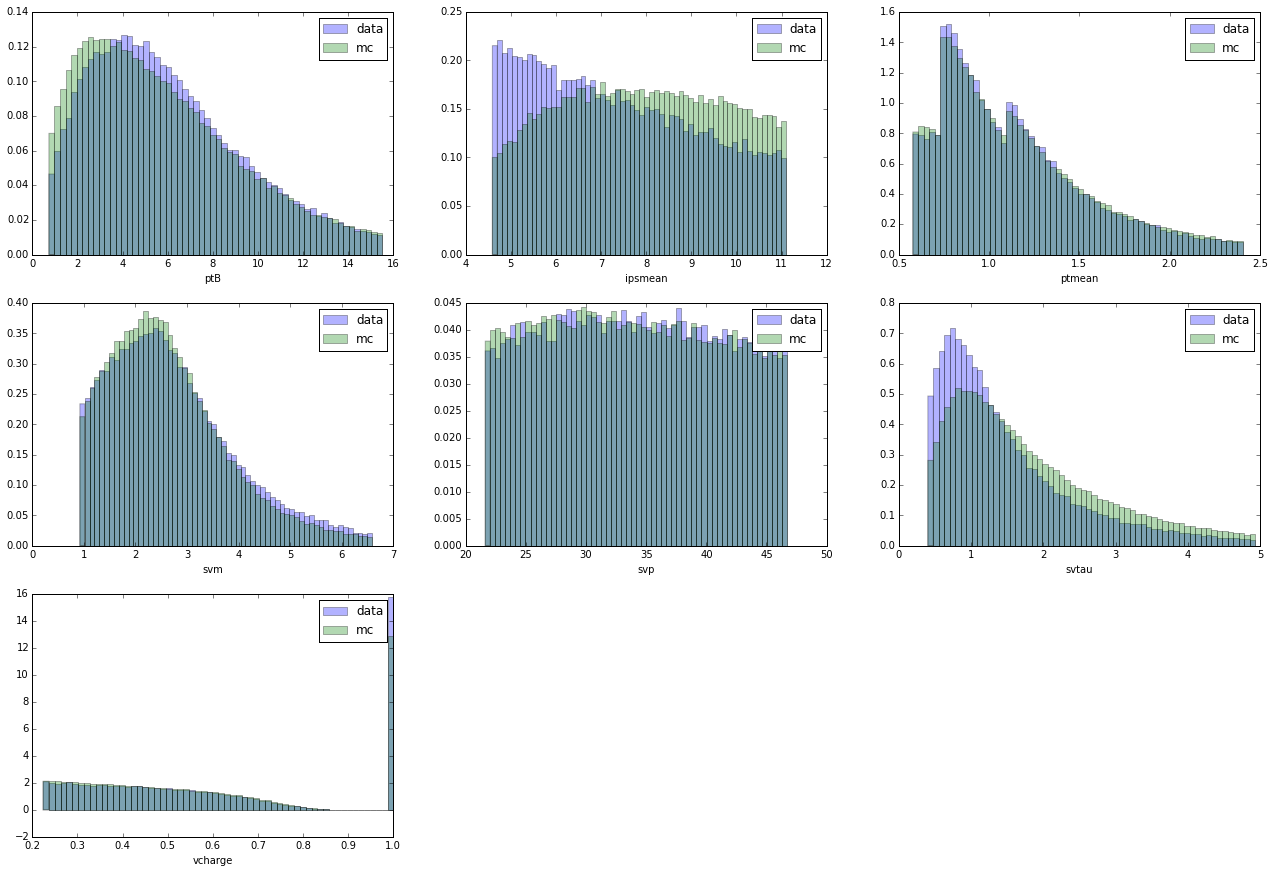

In [29]:
plt.figure(figsize=(22, 20))
for n, f in enumerate(features_new):
    if f == 'svp' or f == 'ipsmean':
        lim_a, lim_b = (10, 40)
    else:
        lim_a, lim_b = (5, 95)
    min_x, max_x = numpy.percentile(data_vertex[f].values, [lim_a, lim_b])
    min_x2, max_x2 = numpy.percentile(mc_vertex.loc[:, f].values, [lim_a, lim_b])
    kw = {'bins': 60, 'alpha': 0.3, 'normed': True, 'range': (min(min_x, min_x2), max(max_x, max_x2))}
    plt.subplot(4, 3, n + 1)
#     
#         plt.hist(data_vertex[f].values, label='data', weights=data_vertex.N_sig_sw.values, **kw)
#         if f == 'vcharge':
#             plt.hist(numpy.log(mc_vertex.loc[old_mask, f].values), 
#                  weights=mc_vertex.N_sig_sw.values[old_mask], label='data new', **kw)
#         else:
#             plt.hist(numpy.log(mc_vertex.loc[old_mask, f].values), 
#                      weights=mc_vertex.N_sig_sw.values[old_mask], label='data new', **kw)
#     else:
    plt.hist(data_vertex[f].values, label='data', weights=data_vertex.N_sig_sw.values, **kw)
    plt.hist(mc_vertex.loc[:, f].values, label='mc', **kw)
#     else:
#         plt.hist(numpy.log(mc_vertex.loc[:, f].values), 
#                  weights=mc_vertex.N_sig_sw.values, label='mc', **kw)
    plt.legend()
#     plt.title(roc_auc_score([1] * len(data_vertex) + [0] * sum(old_mask),
#                             numpy.concatenate([data_vertex[f].values, mc_vertex.loc[old_mask, f].values]),
#                             sample_weight=numpy.concatenate([data_vertex.N_sig_sw.values, [1] * sum(old_mask)])))
    plt.xlabel(f)

# Track

In [ ]:
mc_track = pandas.DataFrame(root_numpy.root2array('datasets/JPsiKMC/MCTracks.root'))
mc_track = mc_track.ix[numpy.isfinite(mc_track.IPs), :]

In [3]:
data_track = pandas.DataFrame(root_numpy.root2array('datasets/tracks.root', 'tracks'))
data_track = data_track.dropna()

In [4]:
mc_track = pandas.read_csv('datasets/data/cvs/JPsiK/Tracks.csv', sep='\t')
mc_track = mc_track.dropna()

In [16]:
!free -m

             total       used       free     shared    buffers     cached
Mem:        100721      66250      34471          0         17        487
-/+ buffers/cache:      65745      34975
Swap:            0          0          0


In [5]:
len(data_track), len(mc_track)

(27156190, 27156190)

In [124]:
min(data_track.ptB.values), max(data_track.ptB.values)

(0.0028712400000000002, 86.541076660000002)

In [22]:
features_track = ['diff_phi', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP',
                  'ptB', 'PIDNNe', 'PIDNNk', 'PIDNNm', 'phi', 'IP', 'IPerr', 'IPs',
                  'veloch', 'ghostProb', 'IPPU', 'eta', 'partlcs']

In [25]:
def plot_tracks(mc_track, data_track, features):
    plt.figure(figsize=(22, 40))
    for n, f in enumerate(features):
        min_x, max_x = numpy.percentile(data_track[f].values, [1, 99])
        min_x2, max_x2 = numpy.percentile(mc_track[f].values, [1, 99])
        kw = {'bins': 60, 'alpha': 0.3, 'normed': True, 'range': (min(min_x, min_x2), max(max_x, max_x2))}
        plt.subplot(7, 3, n + 1)
        plt.hist(data_track[f].values, label='data', weights=data_track.N_sig_sw.values, **kw)
        plt.hist(mc_track[f].values, label='MC', **kw)
        plt.legend()
        plt.title(roc_auc_score([1] * len(data_track) + [0] * len(mc_track),
                                numpy.concatenate([data_track[f].values, mc_track[f].values]),
                                sample_weight=numpy.concatenate([data_track.N_sig_sw.values, [1] * len(mc_track)])))
        plt.xlabel(f)

## all tracks

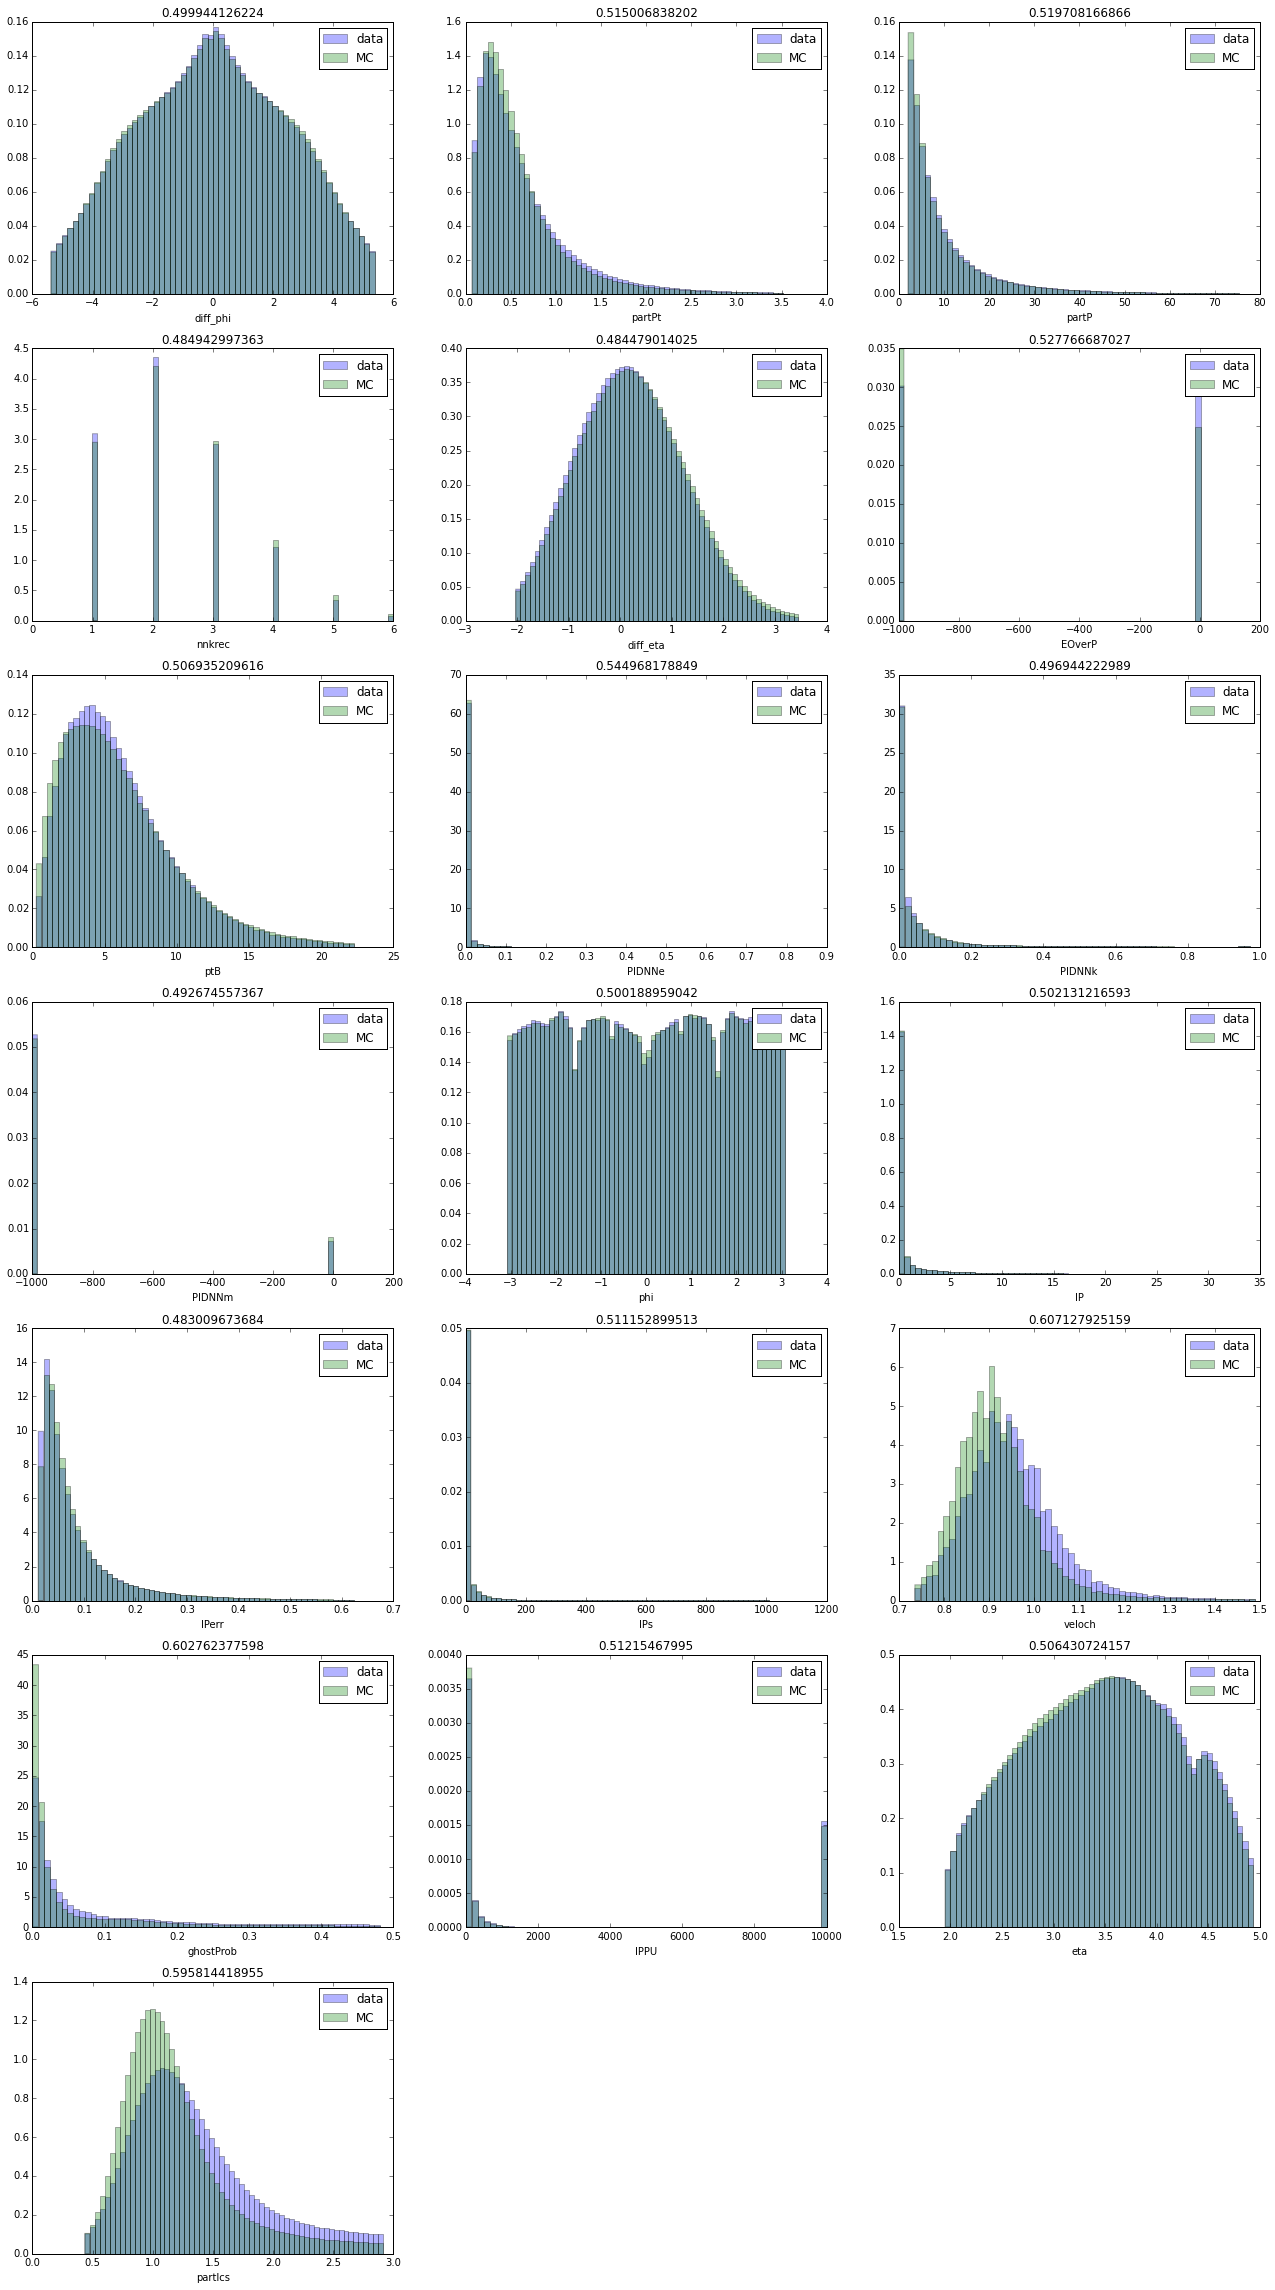

In [26]:
plot_tracks(mc_track, data_track, features_track)

## selected tracks for old tagging

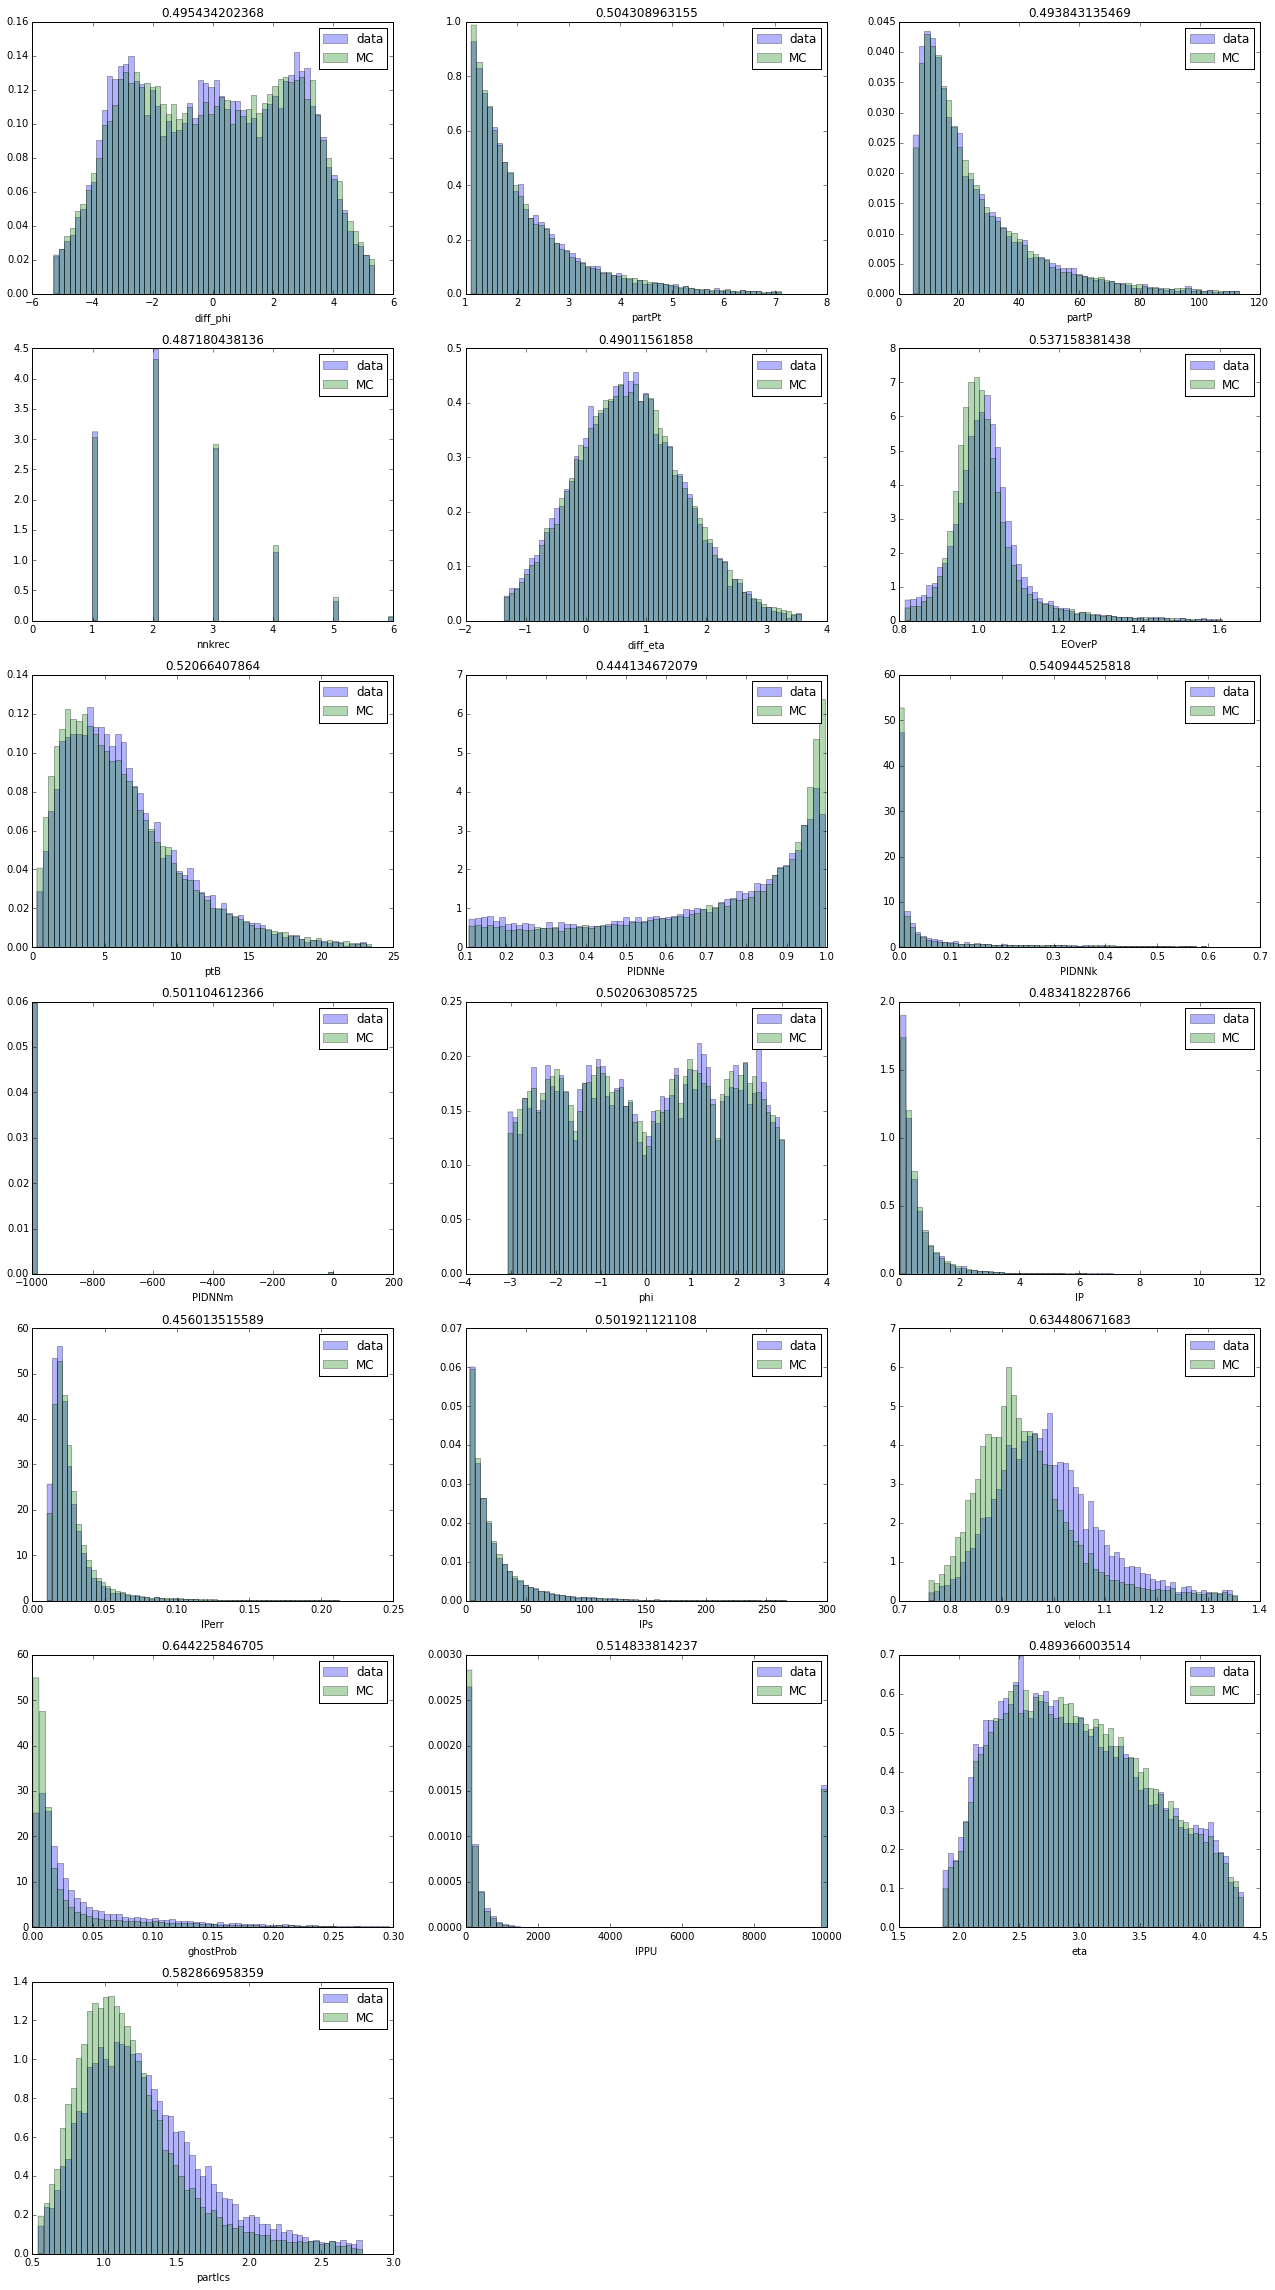

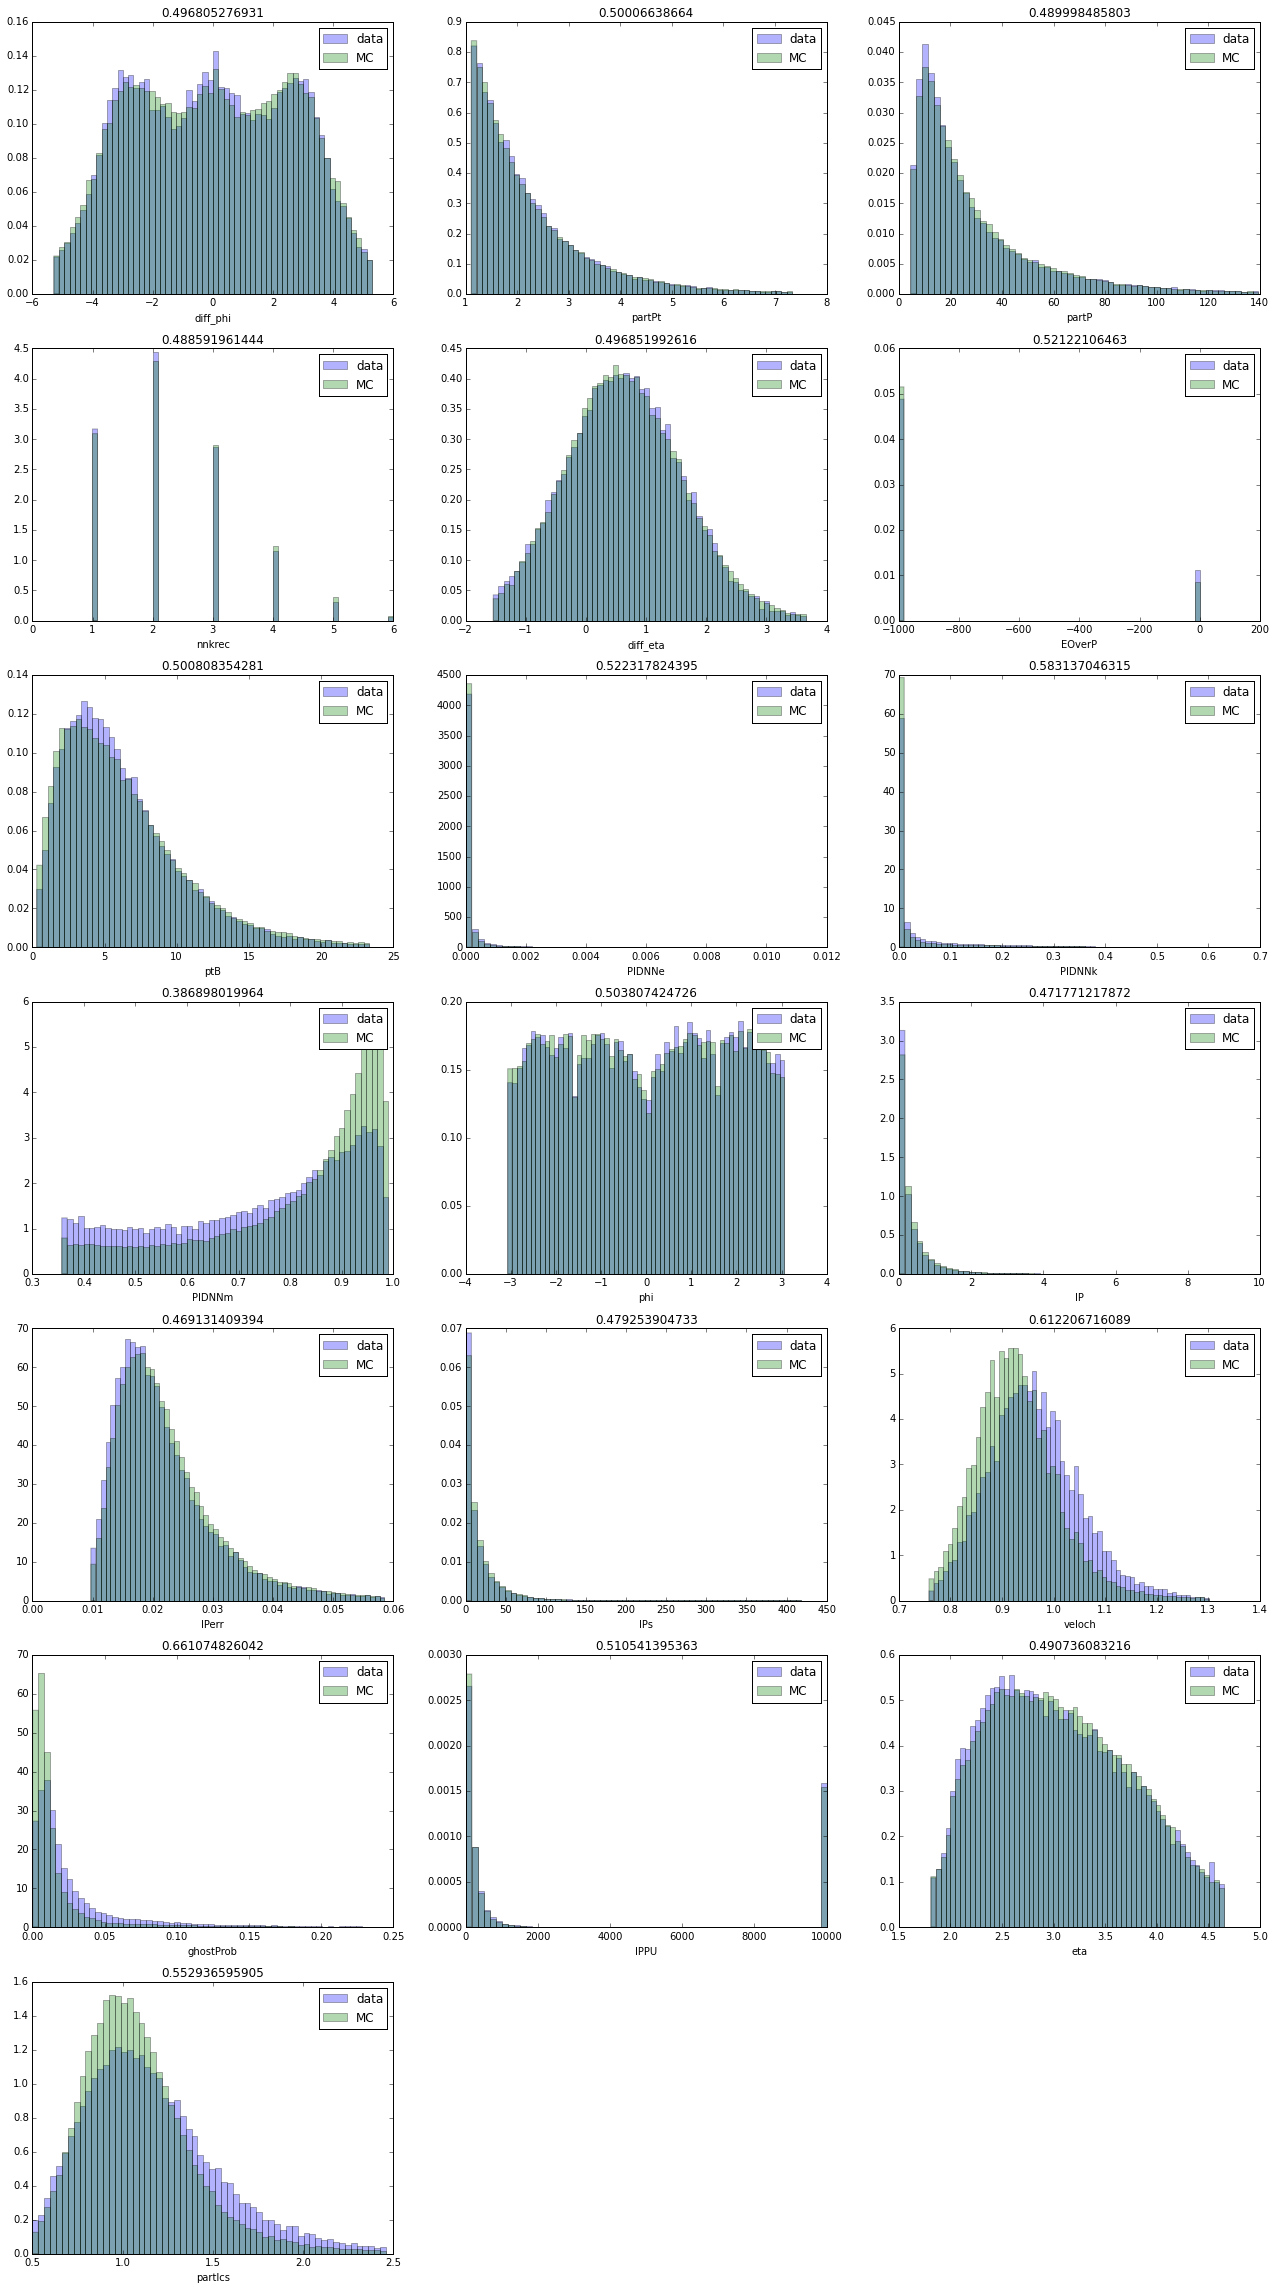

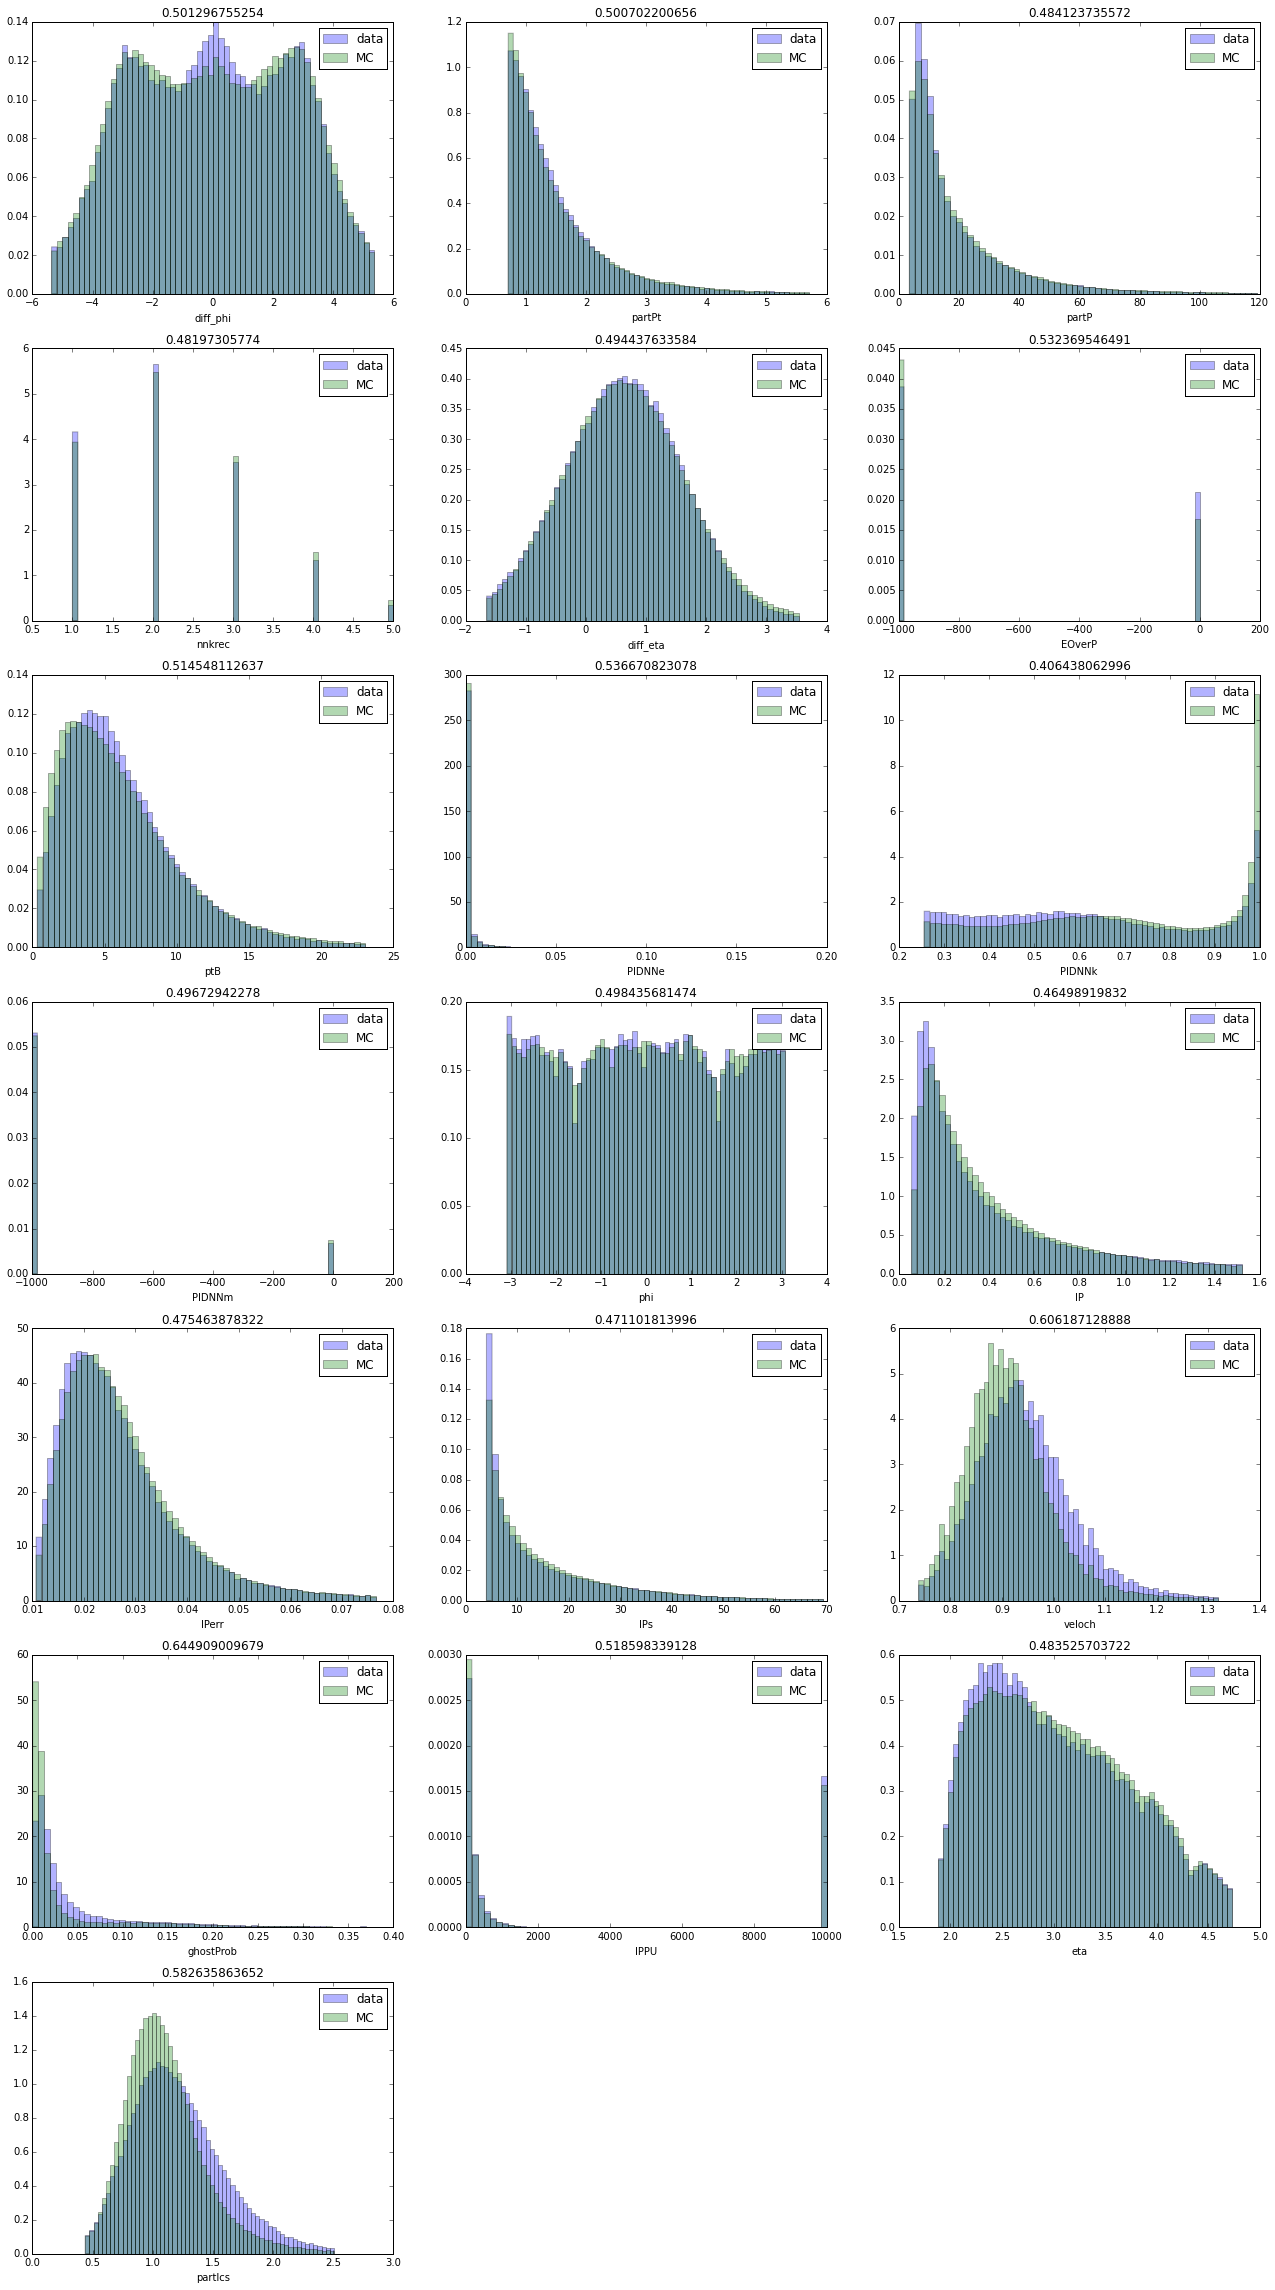

In [27]:
for mask in ['e_cut', 'mu_cut', 'K_cut']:
    plot_tracks(mc_track.ix[mc_track[mask] == 1, :], data_track.ix[data_track[mask] == 1, :], features_track)

## compare B properties

In [44]:
def compute_B_features(data, sign_part_column='signTrack'):
    result_event_id, event_positions, data_ids = numpy.unique(data[event_id_column].values, 
                                                              return_index=True, return_inverse=True)
    charges_sum = -numpy.bincount(data_ids, weights=data[sign_part_column].values)
    sign = numpy.bincount(data_ids, weights=data.signB.values) / numpy.bincount(data_ids)
    weights = numpy.bincount(data_ids, weights=data.N_sig_sw.values) / numpy.bincount(data_ids)
    pt = numpy.bincount(data_ids, weights=data.ptB.values) / numpy.bincount(data_ids)
    return pandas.DataFrame({'pt': pt, 'charges_sum': charges_sum, 'sign': sign, 'weight': weights})

In [30]:
event_id_column = 'event_id'
mc_track[event_id_column] = mc_track.run.apply(str) + '_' + mc_track.event.apply(str)
data_track[event_id_column] = data_track.run.apply(str) + '_' + data_track.event.apply(str)

In [45]:
mc_track['N_sig_sw'] = 1.
Bdata_track_mc = compute_B_features(mc_track)
Bdata_track_data = compute_B_features(data_track)

/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1916600 but corresponding boolean dimension is 1005757
/mnt/mfs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1916600 but corresponding boolean dimension is 1005757


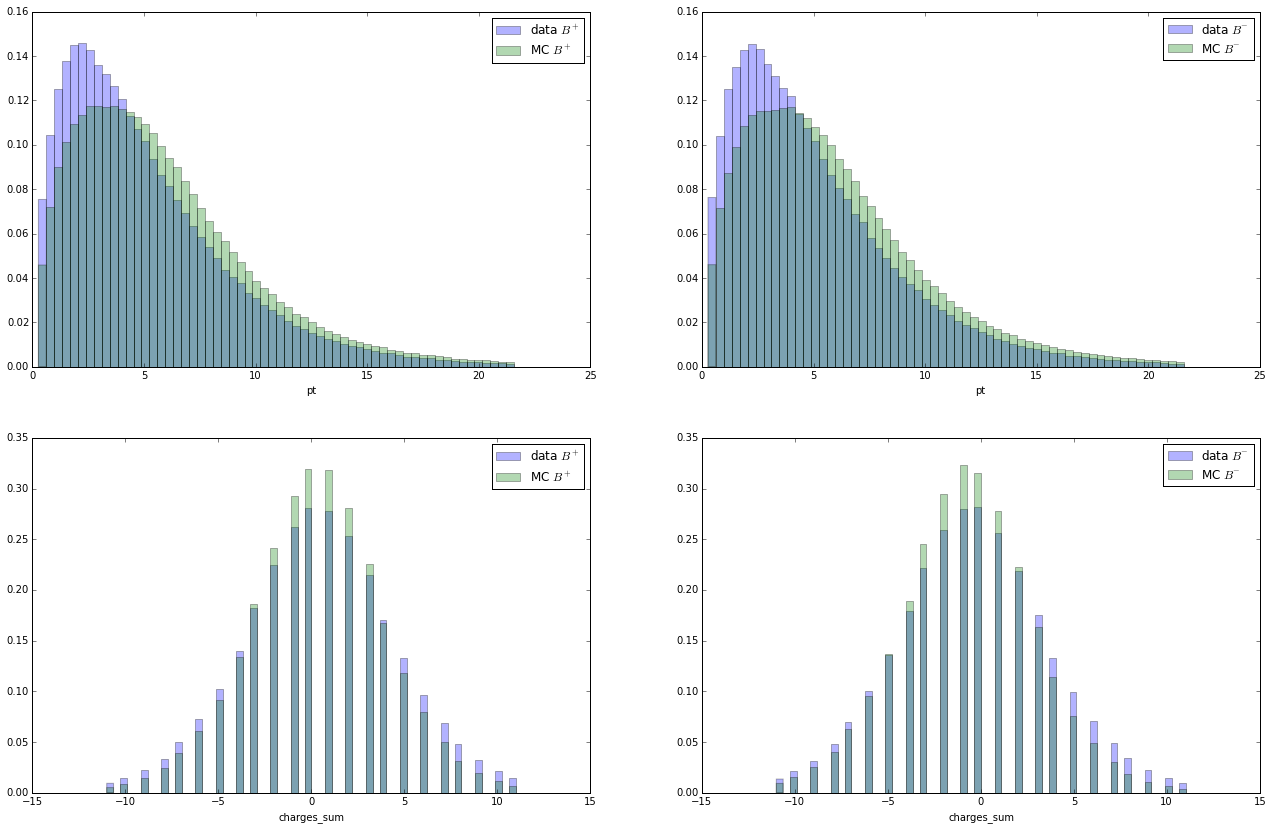

In [72]:
plt.figure(figsize=(22, 14))
for n, f in enumerate(['pt', 'charges_sum']):
    min_x, max_x = numpy.percentile(Bdata_track_data[f].values, [1, 99])
    min_x2, max_x2 = numpy.percentile(Bdata_track_mc[f].values, [1, 99])
    kw = {'bins': 60, 'alpha': 0.3, 'normed': True, 'range': (min(min_x, min_x2), max(max_x, max_x2))}
    
    plt.subplot(2, 2, 2*n + 1)
    mask_mc, mask_data = Bdata_track_mc.sign.values == 1, Bdata_track_data.sign.values == 1
    plt.hist(Bdata_track_data.loc[mask_data, f].values, label='data $B^+$',
             weights=Bdata_track_mc.weight.values[mask_data], **kw)
    plt.hist(Bdata_track_mc.loc[mask_mc, f].values, label='MC $B^+$', **kw)
    plt.legend(); plt.xlabel(f)
    
    plt.subplot(2, 2, 2*n + 2)
    plt.hist(Bdata_track_data.loc[~mask_data, f].values, label='data $B^-$',
             weights=Bdata_track_mc.weight.values[~mask_data], **kw)
    plt.hist(Bdata_track_mc.loc[~mask_mc, f].values, label='MC $B^-$', **kw)
    plt.legend(); plt.xlabel(f)

In [49]:
numpy.mean(Bdata_track_data.charges_sum[Bdata_track_data.sign == 1]), numpy.mean(Bdata_track_data.charges_sum[Bdata_track_data.sign == -1])

(0.4438886851903775, -0.44017678479215078)

In [50]:
numpy.mean(Bdata_track_mc.charges_sum[Bdata_track_mc.sign == 1]), numpy.mean(Bdata_track_mc.charges_sum[Bdata_track_mc.sign == -1])

(0.30906730732373383, -0.76646018620032141)

## sum of charges for MC

In [52]:
roc_auc_score(Bdata_track_mc.sign.values > 0, Bdata_track_mc.charges_sum.values)

0.58411832060079294

## sum of charges for data

In [71]:
roc_auc_score(Bdata_track_data.sign.values > 0, Bdata_track_data.charges_sum.values,
              sample_weight=Bdata_track_data.weight.values)

0.5715786600960916

# Reweight sum of charges

In [55]:
from hep_ml.reweight import GBReweighter

In [58]:
reweighter_charges = GBReweighter(n_estimators=100, learning_rate=0.1, max_depth=3, 
                                  min_samples_leaf=500, loss_regularization=100, gb_args={'subsample': 0.5})

In [111]:
reweighter_charges.fit(Bdata_track_mc[['charges_sum', 'sign']], Bdata_track_data[['charges_sum', 'sign']],
                       Bdata_track_mc.weight.values, Bdata_track_data.weight.values)

GBReweighter(gb_args={'subsample': 0.5}, learning_rate=0.1,
       loss_regularization=100, max_depth=3, min_samples_leaf=500,
       n_estimators=100)

In [113]:
mc_weights = reweighter_charges.predict_weights(Bdata_track_mc[['charges_sum', 'sign']])

In [114]:
print roc_auc_score([0] * len(Bdata_track_mc) + [1] * len(Bdata_track_data),
              numpy.concatenate([Bdata_track_mc.charges_sum.values, Bdata_track_data.charges_sum.values]),
              sample_weight=numpy.concatenate([mc_weights, Bdata_track_data.weight.values]))

print roc_auc_score([0] * len(Bdata_track_mc) + [1] * len(Bdata_track_data),
              numpy.concatenate([Bdata_track_mc.charges_sum.values, Bdata_track_data.charges_sum.values]),
              sample_weight=numpy.concatenate([mc_weights * 0 + 1, Bdata_track_data.weight.values]))

0.499979399877
0.510605933748


In [115]:
mask_mc, mask_data = Bdata_track_mc.sign.values == 1, Bdata_track_data.sign.values == 1

print roc_auc_score([0] * sum(mask_mc) + [1] * sum(mask_data),
              numpy.concatenate([Bdata_track_mc.charges_sum.values[mask_mc], Bdata_track_data.charges_sum.values[mask_data]]),
              sample_weight=numpy.concatenate([[1] * sum(mask_mc), Bdata_track_data.weight.values[mask_data]]))
print roc_auc_score([0] * sum(mask_mc) + [1] * sum(mask_data),
              numpy.concatenate([Bdata_track_mc.charges_sum.values[mask_mc], Bdata_track_data.charges_sum.values[mask_data]]),
              sample_weight=numpy.concatenate([mc_weights[mask_mc], Bdata_track_data.weight.values[mask_data]]))

0.508312358593
0.499651342665


In [116]:
mask_mc, mask_data = Bdata_track_mc.sign.values == -1, Bdata_track_data.sign.values == -1

print roc_auc_score([0] * sum(mask_mc) + [1] * sum(mask_data),
              numpy.concatenate([Bdata_track_mc.charges_sum.values[mask_mc], Bdata_track_data.charges_sum.values[mask_data]]),
              sample_weight=numpy.concatenate([[1] * sum(mask_mc), Bdata_track_data.weight.values[mask_data]]))

print roc_auc_score([0] * sum(mask_mc) + [1] * sum(mask_data),
              numpy.concatenate([Bdata_track_mc.charges_sum.values[mask_mc], Bdata_track_data.charges_sum.values[mask_data]]),
              sample_weight=numpy.concatenate([mc_weights[mask_mc], Bdata_track_data.weight.values[mask_data]]))

0.512541344918
0.500303074033


In [117]:
roc_auc_score(Bdata_track_mc.sign.values > 0, Bdata_track_mc.charges_sum.values, 
              sample_weight=mc_weights)

0.57227330623125949

In [118]:
roc_auc_score(Bdata_track_data.sign.values > 0, Bdata_track_data.charges_sum.values, 
              sample_weight=Bdata_track_data.weight.values)

0.5715786600960916

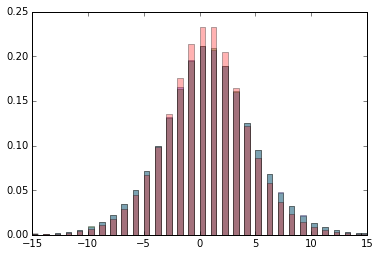

In [119]:
mask_mc, mask_data = Bdata_track_mc.sign.values == 1, Bdata_track_data.sign.values == 1

plt.hist(Bdata_track_data['charges_sum'].values[mask_data], label='data $B^+$',
         weights=Bdata_track_data.weight.values[mask_data], **kw)
plt.hist(Bdata_track_mc['charges_sum'].values[mask_mc], label='MC $B^+$',
         weights=mc_weights[mask_mc], **kw)
plt.hist(Bdata_track_mc['charges_sum'].values[mask_mc], label='MC $B^+$', **kw)

pass

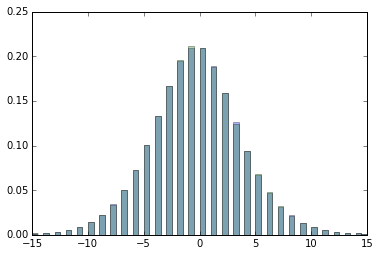

In [120]:
mask_mc, mask_data = Bdata_track_mc.sign.values == -1, Bdata_track_data.sign.values == -1

plt.hist(Bdata_track_data['charges_sum'].values[mask_data], label='data $B^+$',
         weights=Bdata_track_data.weight.values[mask_data], **kw)
plt.hist(Bdata_track_mc['charges_sum'].values[mask_mc], label='MC $B^+$',
         weights=mc_weights[mask_mc], **kw)
# plt.hist(Bdata_track_mc['charges_sum'].values[mask_mc], label='MC $B^+$', **kw)

pass

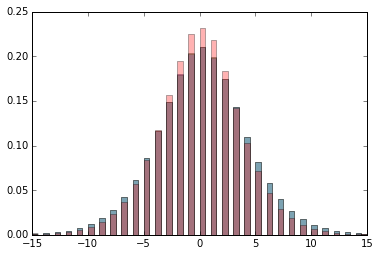

In [121]:
plt.hist(Bdata_track_data['charges_sum'].values, label='data',
         weights=Bdata_track_data.weight.values, **kw)
plt.hist(Bdata_track_mc['charges_sum'].values, label='MC',
         weights=mc_weights, **kw)
plt.hist(Bdata_track_mc['charges_sum'].values, label='MC', **kw)
pass